In [1]:
from os import path

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits, ascii
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import minimize
from pyia import GaiaData

import gala.coordinates as gc
import gala.dynamics as gd
from gala.dynamics import mockstream
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.mpl_style import center_emph

In [2]:
plt.style.use('notebook')

In [3]:
R = np.load('../data/jhelum_rotmat_init.npy')
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_transpose

class Jhelum(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the track of the PS1-A stream

    For more information about this class, see the Astropy documentation
    on coordinate frames in :mod:`~astropy.coordinates`.

    Parameters
    ----------
    representation : :class:`~astropy.coordinates.BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)

    phi1 : angle_like, optional, must be keyword
        The longitude-like angle corresponding to Orphan's orbit.
    phi2 : angle_like, optional, must be keyword
        The latitude-like angle corresponding to Orphan's orbit.
    distance : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    pm_phi1_cosphi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the longitude-like direction corresponding to
        the Orphan stream's orbit.
    pm_phi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the latitude-like direction perpendicular to the
        Orphan stream's orbit.
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    """
    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'phi1'),
            coord.RepresentationMapping('lat', 'phi2'),
            coord.RepresentationMapping('distance', 'distance')],
        coord.SphericalCosLatDifferential: [
            coord.RepresentationMapping('d_lon_coslat', 'pm_phi1_cosphi2'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')],
        coord.SphericalDifferential: [
            coord.RepresentationMapping('d_lon', 'pm_phi1'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    frame_specific_representation_info[coord.UnitSphericalRepresentation] = \
        frame_specific_representation_info[coord.SphericalRepresentation]
    frame_specific_representation_info[coord.UnitSphericalCosLatDifferential] = \
        frame_specific_representation_info[coord.SphericalCosLatDifferential]
    frame_specific_representation_info[coord.UnitSphericalDifferential] = \
        frame_specific_representation_info[coord.SphericalDifferential]


@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.ICRS, Jhelum)
def icrs_to_jhelum():
    """ Compute the transformation from Galactic spherical to
        heliocentric Jhelum coordinates.
    """
    return R

@frame_transform_graph.transform(coord.StaticMatrixTransform, Jhelum, coord.ICRS)
def jhelum_to_icrs():
    """ Compute the transformation from heliocentric Jhelum coordinates to
        spherical Galactic.
    """
    return matrix_transpose(icrs_to_jhelum())

In [4]:
dt = 0.5 * u.Myr
n_steps = 200
wangle = 180*u.deg

_phi2_sigma = 0.5 # deg
_dist_sigma = 0.1 # kpc
_vr_sigma = 1 # km/s

def ln_likelihood(p, phi1_0, data, ham, gc_frame):
    # initial conditions at phi1_0
    phi2, d, pm1, pm2, vr = p
    
    c = Jhelum(phi1=phi1_0, phi2=phi2*u.deg, distance=d*u.kpc, 
               pm_phi1_cosphi2=pm1*u.mas/u.yr,
               pm_phi2=pm2*u.mas/u.yr,
               radial_velocity=vr*u.km/u.s)
    w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)
    
    orbit = ham.integrate_orbit(w0, dt=dt, n_steps=n_steps)
    model_jhelum = orbit.to_coord_frame(Jhelum, galactocentric_frame=gc_frame)
    
    model_x = model_jhelum.phi1.wrap_at(wangle).degree
    if model_x[-1] < -180:
        return -np.inf
    
    model_phi2 = model_jhelum.phi2.degree
    model_dist = model_jhelum.distance.to(u.kpc).value
    model_pm1 = model_jhelum.pm_phi1_cosphi2.to(u.mas/u.yr).value
    model_pm2 = model_jhelum.pm_phi2.to(u.mas/u.yr).value
    model_vr = model_jhelum.radial_velocity.to(u.km/u.s).value
    
    # plt.errorbar(data['phi2'][0], data['phi2'][1], marker='o', linestyle='none')
#     plt.errorbar(data['pm2'][0], data['pm2'][1], marker='o', linestyle='none')
#     plt.plot(model_x, model_pm2)
#     return
    
    ix = np.argsort(model_x)
    model_x = model_x[ix]
    
    # define interpolating functions
    order = 3
    bbox = [-180, 180]
    
    chi2 = 0
    
    phi2_interp = InterpolatedUnivariateSpline(model_x, model_phi2[ix], 
                                               k=order, bbox=bbox)
    dist_interp = InterpolatedUnivariateSpline(model_x, model_dist[ix], 
                                               k=order, bbox=bbox)
    pm1_interp = InterpolatedUnivariateSpline(model_x, model_pm1[ix], 
                                              k=order, bbox=bbox)
    pm2_interp = InterpolatedUnivariateSpline(model_x, model_pm2[ix], 
                                              k=order, bbox=bbox)
#     vr_interp = InterpolatedUnivariateSpline(model_x, model_vr[ix], 
#                                              k=order, bbox=bbox)
    
    phi2_sigma = np.sqrt(_phi2_sigma**2 + data['phi2'][2]**2)
    chi2 += np.sum(-(phi2_interp(data['phi2'][0]) - data['phi2'][1])**2 / phi2_sigma**2 - 2*np.log(phi2_sigma))
    
    dist_sigma = np.sqrt(_dist_sigma**2 + data['dist'][2]**2)
    chi2 += np.sum(-(dist_interp(data['dist'][0]) - data['dist'][1])**2 / dist_sigma**2 - 2*np.log(dist_sigma))
    
    pm1_sigma = data['pm1'][2]
    chi2 += np.sum(-(pm1_interp(data['pm1'][0]) - data['pm1'][1])**2 / pm1_sigma**2 - 2*np.log(pm1_sigma))
    
    pm2_sigma = data['pm2'][2]
    chi2 += np.sum(-(pm2_interp(data['pm2'][0]) - data['pm2'][1])**2 / pm2_sigma**2 - 2*np.log(pm2_sigma))
    
#     vr_sigma = np.sqrt(data['vr'][2]**2 + _vr_sigma**2)
#     chi2 += np.sum(-(vr_interp(data['vr'][0]) - data['vr'][1])**2 / vr_sigma**2 - 2*np.log(vr_sigma))

    return chi2

In [5]:
tdata = Table.read('../data/jhelum_track_narrow.fits')

In [6]:
print(np.median(tdata['dist']), np.median(tdata['dist_err']))

13.0 3.746739625930786


In [7]:
d0 = np.median(tdata['dist'])
derr = np.median(tdata['dist_err'])

N = 10
distances = np.linspace(d0-derr,d0+derr,N)

In [8]:
distances

array([ 9.25326037, 10.08586918, 10.91847799, 11.75108679, 12.5836956 ,
       13.4163044 , 14.24891321, 15.08152201, 15.91413082, 16.74673963])

In [9]:
data = []

for dist in distances:
    data_ = dict()

    data_['phi2'] = (tdata['phi1'], tdata['phi2'], tdata['w'])
    data_['dist'] = (tdata['phi1'], np.ones(np.size(tdata['dist']))*dist, tdata['dist_err'])
    data_['pm1'] = (tdata['phi1'], tdata['pm1'], tdata['pm1_err'])
    data_['pm2'] = (tdata['phi1'], tdata['pm2'], tdata['pm2_err'])
    
    data += [data_]

In [10]:
ham = gp.Hamiltonian(gp.MilkyWayPotential(nucleus=dict(m=0), 
                                          halo=dict(c=0.95, m=7E11),
                                          bulge=dict(m=4E9),
                                          disk=dict(m=5.5e10)))

gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc, z_sun=0*u.pc)
phi1_0 = 25. * u.deg
p0 = (1.05370676, 12.63987863, -7.29853578, 2.92066282, -82.57164503)

In [11]:
res = []
for i in range(N):
    res_ = minimize(lambda *x: -ln_likelihood(*x), x0=p0, args=(phi1_0, data[i], ham, gc_frame))
    res += [res_]

In [12]:
import pickle

In [13]:
pickle.dump({'res': res}, open('../data/orbits_distance.{:d}.pkl'.format(N), 'wb'))

In [14]:
dt = 0.5*u.Myr

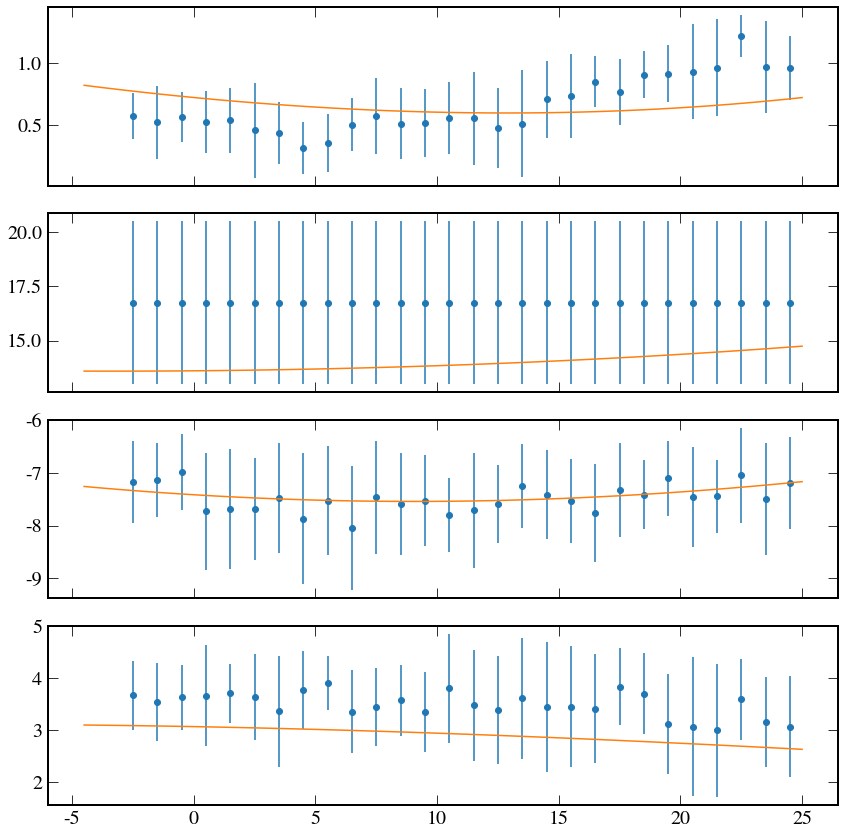

In [15]:
ind = 1
for ind in range(N):
    plt.close()
    fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

    axes[0].errorbar(data[ind]['phi2'][0], data[ind]['phi2'][1], data[ind]['phi2'][2], marker='o', linestyle='none')
    axes[1].errorbar(data[ind]['dist'][0], data[ind]['dist'][1], data[ind]['dist'][2], marker='o', linestyle='none')
    axes[2].errorbar(data[ind]['pm1'][0], data[ind]['pm1'][1], data[ind]['pm1'][2], marker='o', linestyle='none')
    axes[3].errorbar(data[ind]['pm2'][0], data[ind]['pm2'][1], data[ind]['pm2'][2], marker='o', linestyle='none')

    phi2, d, pm1, pm2, vr = res[ind].x

    c = Jhelum(phi1=phi1_0, phi2=phi2*u.deg, distance=d*u.kpc, 
               pm_phi1_cosphi2=pm1*u.mas/u.yr,
               pm_phi2=pm2*u.mas/u.yr,
               radial_velocity=vr*u.km/u.s)
    w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

    fit_orbit = ham.integrate_orbit(w0, dt=dt, n_steps=38)
    model_jhelum = fit_orbit.to_coord_frame(Jhelum, galactocentric_frame=gc_frame)

    model_x = model_jhelum.phi1.wrap_at(wangle).degree

    axes[0].plot(model_x, model_jhelum.phi2.degree, marker='', zorder=100)
    axes[1].plot(model_x, model_jhelum.distance, marker='', zorder=100)
    axes[2].plot(model_x, model_jhelum.pm_phi1_cosphi2.to(u.mas/u.yr).value, marker='', zorder=100)
    axes[3].plot(model_x, model_jhelum.pm_phi2.to(u.mas/u.yr).value, marker='', zorder=100)
    # axes[4].plot(model_x, model_gd1.radial_velocity.to(u.km/u.s).value, marker='', zorder=100)
    plt.tight_layout()
    plt.savefig('../plots/orbit_fit_distance.{:.1f}.png'.format(distances[ind]))

In [26]:
orbits = []
stream = []
models = []
long_model = []

for i in range(N):
    phi2, d, pm1, pm2, vr = res[i].x
    c = Jhelum(phi1=phi1_0, phi2=phi2*u.deg, distance=d*u.kpc, 
               pm_phi1_cosphi2=pm1*u.mas/u.yr,
               pm_phi2=pm2*u.mas/u.yr,
               radial_velocity=vr*u.km/u.s)
    w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

    orbit_rr = ham.integrate_orbit(w0, dt=-0.5, t1=0*u.Myr, t2=-5000*u.Myr)
    orbits += [orbit_rr]
    
    model_ = orbit_rr.to_coord_frame(Jhelum, galactocentric_frame=gc_frame)
    long_model += [model_]
    
    orbit_stream = ham.integrate_orbit(w0, dt=dt, n_steps=38)
    stream += [orbit_stream]
    
    model_ = orbit_stream.to_coord_frame(Jhelum, galactocentric_frame=gc_frame)
    models += [model_]

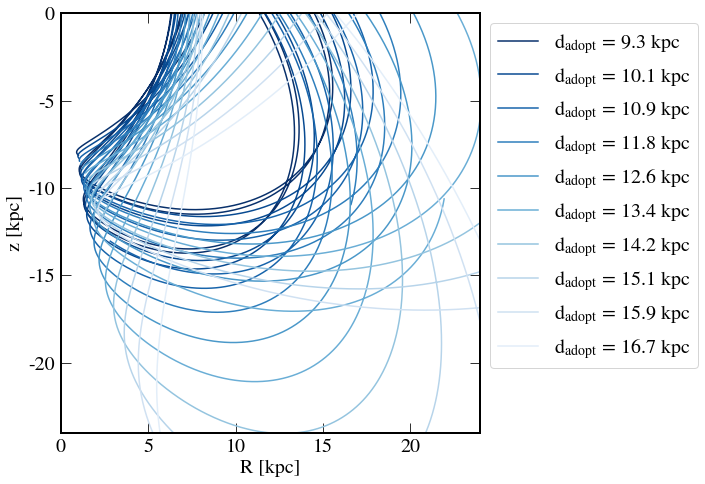

In [17]:
imax = 3000
plt.figure(figsize=(10,10))
for i in range(N):
    plt.plot(orbits[i].cylindrical.rho[:imax], orbits[i].cylindrical.z[:imax], '-', color=mpl.cm.Blues(1-i/N),
             label='d$_{{adopt}}$ = {:.1f} kpc'.format(distances[i]))

plt.xlim(0,24)
plt.ylim(-24,0)
plt.gca().set_aspect('equal')

plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')

plt.tight_layout()

In [18]:
def jhelum_dist(phi1, d0=12.8, d1=0, d2=0):
    p1, p2 = 0, 20
    if (d1==0) | (d2==0):
        d1, d2 = d0, d0
    m = (d2-d1) / (p2-p1)
    return (m*(phi1.wrap_at(wangle).value - p1) + d1) * u.kpc

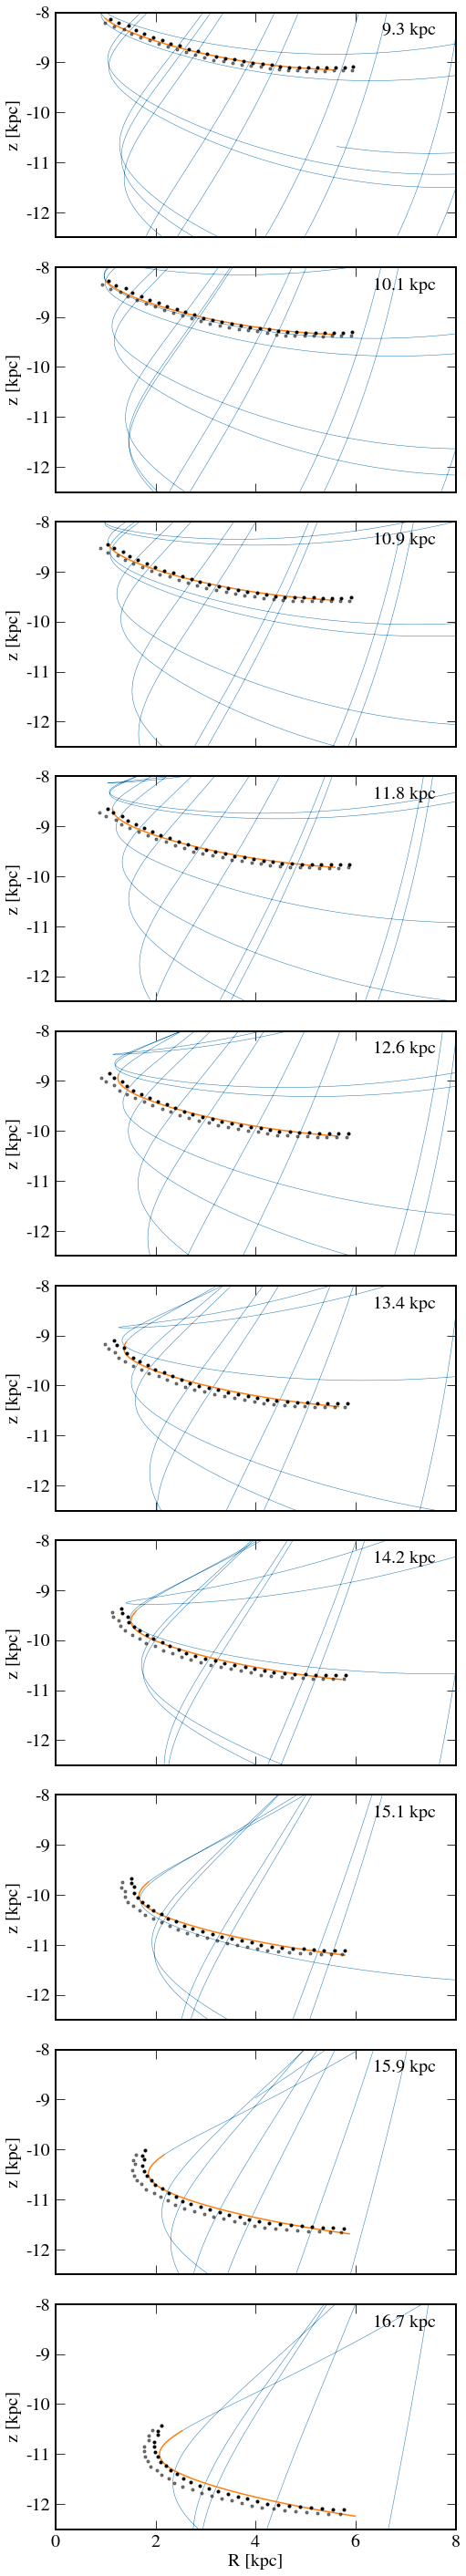

In [19]:
fig, ax = plt.subplots(N,1,figsize=(7,4*N), sharex=True, sharey=True)
imax = 10000
for i in range(N):
    plt.sca(ax[i])
    plt.plot(orbits[i].cylindrical.rho[:imax], orbits[i].cylindrical.z[:imax], '-', lw=0.5)
    plt.plot(stream[i].cylindrical.rho, stream[i].cylindrical.z, '-')
    
    i1 = np.argmin(np.abs(models[i].phi1.wrap_at(wangle)))
    i2 = np.argmin(np.abs(models[i].phi1.wrap_at(wangle)-20*u.deg))
    d1, d2 = models[i].distance[i1].value, models[i].distance[i2].value

#     c = Jhelum(phi1=data[i]['phi2'][0]*u.deg, phi2=data[i]['phi2'][1], distance=data[i]['dist'][1]*u.kpc)
    c = Jhelum(phi1=data[i]['phi2'][0]*u.deg, phi2=data[i]['phi2'][1],
               distance=jhelum_dist(coord.Angle(data[i]['phi2'][0]*u.deg), d1=d1, d2=d2))
    cgal = c.transform_to(coord.Galactocentric)
    R = np.sqrt(cgal.x**2 + cgal.y**2)
    plt.plot(R, cgal.z, 'k.')
    
#     c = Jhelum(phi1=data[i]['phi2'][0]*u.deg, phi2=data[i]['phi2'][1]-0.9*u.deg, distance=data[i]['dist'][1]*u.kpc)
    c = Jhelum(phi1=data[i]['phi2'][0]*u.deg, phi2=data[i]['phi2'][1]-0.9*u.deg,
               distance=jhelum_dist(coord.Angle(data[i]['phi2'][0]*u.deg), d1=d1, d2=d2))
    cgal = c.transform_to(coord.Galactocentric)
    R = np.sqrt(cgal.x**2 + cgal.y**2)
    plt.plot(R, cgal.z, 'k.', alpha=0.5)

    plt.xlim(0,8)
    plt.ylim(-12.5,-8)
    plt.gca().set_aspect('equal')
    plt.ylabel('z [kpc]')
    plt.text(0.95,0.9,'{:.1f} kpc'.format(distances[i]), transform=plt.gca().transAxes, ha='right')
    
plt.xlabel('R [kpc]')
plt.tight_layout(h_pad=0)
plt.savefig('../plots/orbit_Rz_distances.png')

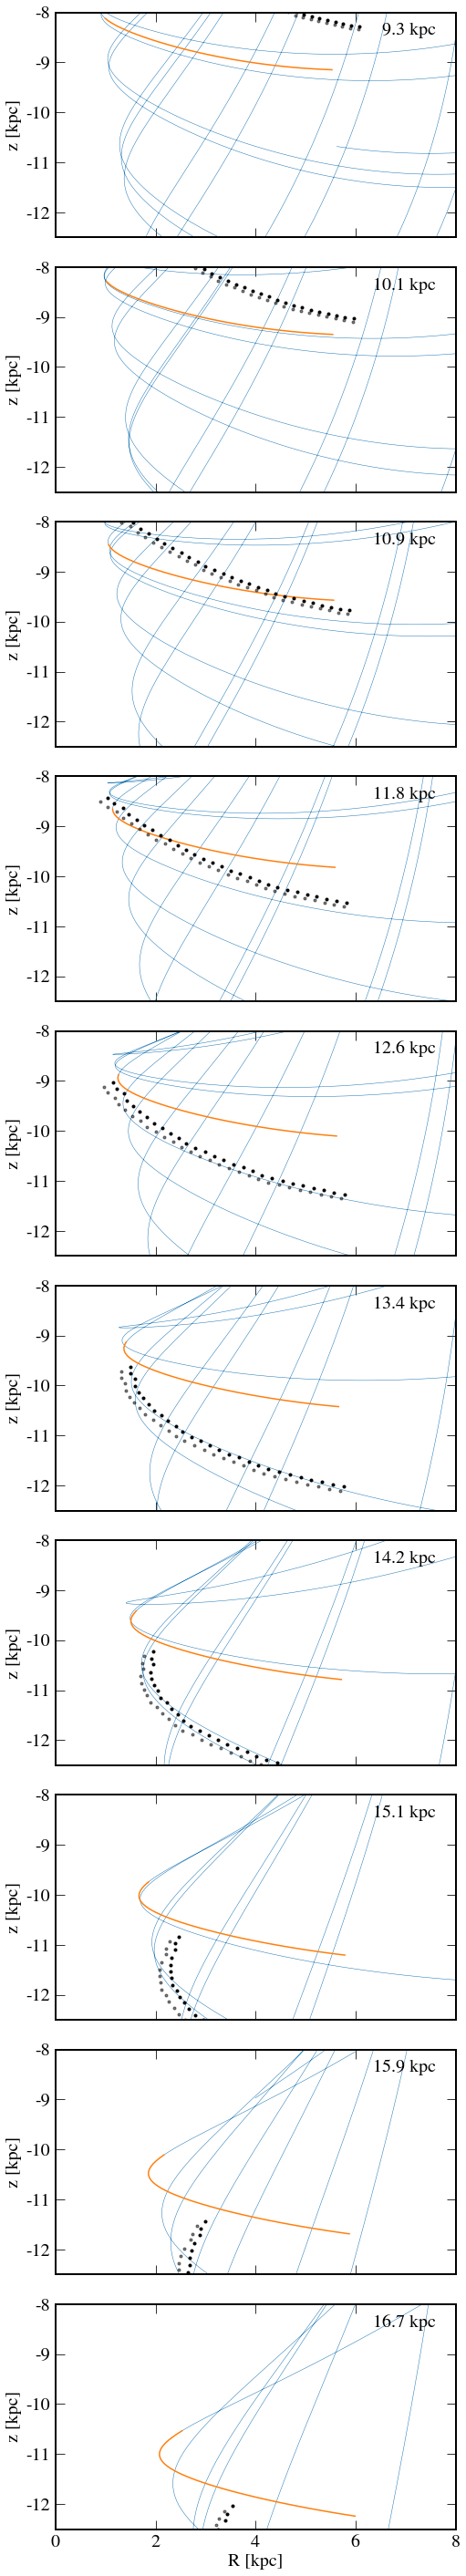

In [20]:
fig, ax = plt.subplots(N,1,figsize=(7,4*N), sharex=True, sharey=True)
imax = 10000
for i in range(N):
    plt.sca(ax[i])
    plt.plot(orbits[i].cylindrical.rho[:imax], orbits[i].cylindrical.z[:imax], '-', lw=0.5)
    plt.plot(stream[i].cylindrical.rho, stream[i].cylindrical.z, '-')
    
    i1 = np.argmin(np.abs(models[i].phi1.wrap_at(wangle)))
    i2 = np.argmin(np.abs(models[i].phi1.wrap_at(wangle)-20*u.deg))
    d1, d2 = models[i].distance[i1].value, models[i].distance[i2].value

    c = Jhelum(phi1=data[i]['phi2'][0]*u.deg, phi2=data[i]['phi2'][1], distance=data[i]['dist'][1]*u.kpc)
#     c = Jhelum(phi1=data[i]['phi2'][0]*u.deg, phi2=data[i]['phi2'][1],
#                distance=jhelum_dist(coord.Angle(data[i]['phi2'][0]*u.deg), d1=d1, d2=d2))
    cgal = c.transform_to(coord.Galactocentric)
    R = np.sqrt(cgal.x**2 + cgal.y**2)
    plt.plot(R, cgal.z, 'k.')
    
    c = Jhelum(phi1=data[i]['phi2'][0]*u.deg, phi2=data[i]['phi2'][1]-0.9*u.deg, distance=data[i]['dist'][1]*u.kpc)
#     c = Jhelum(phi1=data[i]['phi2'][0]*u.deg, phi2=data[i]['phi2'][1]-0.9*u.deg,
#                distance=jhelum_dist(coord.Angle(data[i]['phi2'][0]*u.deg), d1=d1, d2=d2))
    cgal = c.transform_to(coord.Galactocentric)
    R = np.sqrt(cgal.x**2 + cgal.y**2)
    plt.plot(R, cgal.z, 'k.', alpha=0.5)

    plt.xlim(0,8)
    plt.ylim(-12.5,-8)
    plt.gca().set_aspect('equal')
    plt.ylabel('z [kpc]')
    plt.text(0.95,0.9,'{:.1f} kpc'.format(distances[i]), transform=plt.gca().transAxes, ha='right')
    
plt.xlabel('R [kpc]')
plt.tight_layout(h_pad=0)
plt.savefig('../plots/orbit_Rz_distances_const.png')

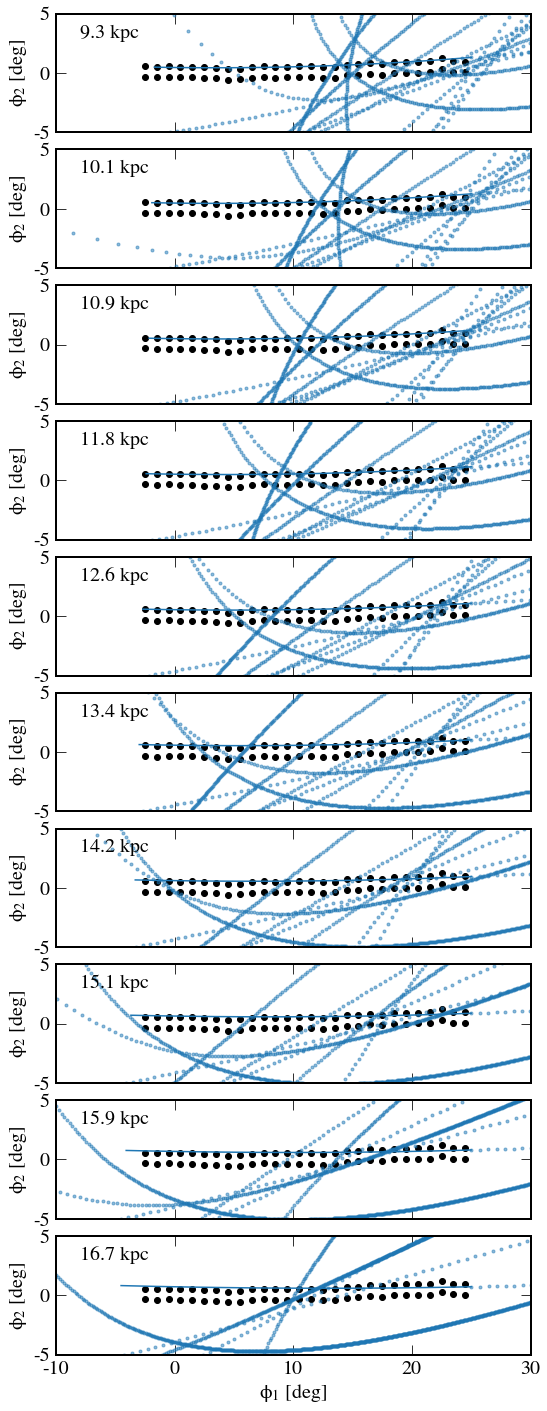

In [41]:
fig, ax = plt.subplots(N,1,figsize=(20,20), sharex=True, sharey=True)

for i in range(N):
    plt.sca(ax[i])
    c = Jhelum(phi1=data[i]['phi2'][0]*u.deg, phi2=data[i]['phi2'][1], distance=data[i]['dist'][1]*u.kpc)
    plt.plot(c.phi1.wrap_at(wangle), c.phi2, 'ko')
    c2 = Jhelum(phi1=data[i]['phi2'][0]*u.deg, phi2=data[i]['phi2'][1]-0.9*u.deg, distance=data[i]['dist'][1]*u.kpc)
    plt.plot(c2.phi1.wrap_at(wangle), c2.phi2, 'ko')

    plt.plot(models[i].phi1.wrap_at(wangle), models[i].phi2, '-', color='tab:blue', alpha=1)
    plt.plot(long_model[i].phi1.wrap_at(wangle), long_model[i].phi2, '.', color='tab:blue', alpha=0.5)

    plt.xlim(-10,30)
    plt.ylim(-5,5)
    plt.gca().set_aspect('equal')
    plt.ylabel('$\phi_2$ [deg]')
    plt.text(0.05,0.8,'{:.1f} kpc'.format(distances[i]), transform=plt.gca().transAxes, ha='left')

plt.xlabel('$\phi_1$ [deg]')

plt.tight_layout(h_pad=0)

## check Indus

In [43]:
ra_ind = np.array([-36.3, -8])*u.deg
dec_ind = np.array([-50.7, -64.8])*u.deg
d_ind = np.array([16.6, 17.1])*u.kpc

cind = coord.SkyCoord(ra=ra_ind, dec=dec_ind, distance=d_ind, frame='icrs')
cind_gal = cind.transform_to(coord.Galactocentric)
Rind = np.sqrt(cind_gal.y**2 + cind_gal.x**2)

indus_frame = gc.GreatCircleICRSFrame.from_endpoints(cind[0], cind[1])
cind_nat = cind.transform_to(indus_frame)
cind_line = coord.SkyCoord(phi1=np.linspace(cind_nat.phi1.wrap_at(wangle)[0], 
                                            cind_nat.phi1.wrap_at(wangle)[1],20),
                       phi2=np.zeros(20)*u.deg, distance=np.linspace(16.6,17.2,20)*u.kpc, frame=indus_frame)

In [44]:
cind_jh = cind_line.transform_to(Jhelum)

14.248913208643597


(-5, 20)

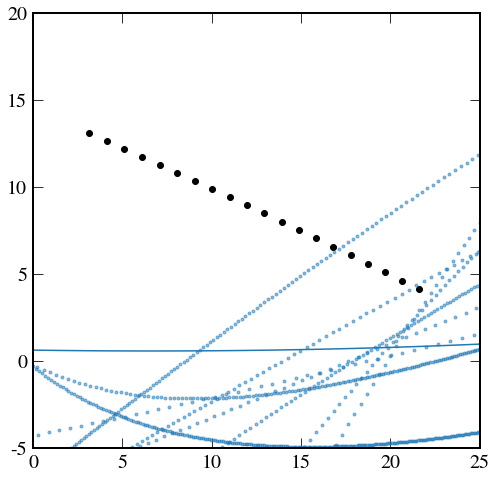

In [54]:
plt.plot(cind_jh.phi1, cind_jh.phi2, 'ko')

i = 6
print(distances[i])
plt.plot(models[i].phi1.wrap_at(wangle), models[i].phi2, '-', color='tab:blue', alpha=1)
plt.plot(long_model[i].phi1.wrap_at(wangle), long_model[i].phi2, '.', color='tab:blue', alpha=0.5)

plt.xlim(0,25)
plt.ylim(-5,20)
